# Online to Offline: where is the best place to settle?

## Intro

This project aims to assist online businesses to go offline by helping them choosing the best place to open their physical location close to their customers.

### How does the model work?

1. Gather the geographical information of users (coordinates/addresses)
2. Define a unique location for each user (mean)
3. Build clusters to regroup users
4. Analyze the clusters’ regions
5. Find the best spot to rent / buy a place (via Zap Imóveis)

### For whom it can be useful?


Any business that has its customer locations, such as:

1. Restaurants with Delivery Customer data
2. Companies that want to move their office
3. E-commerce shops that wish to implement storage closer to their clients

## 1. Data: importing and cleaning

We worked with some data from Appito - an app to organize soccer games. Before the pandemic, they had around 140.000 active users and organizes around 4.000 games per week. To develop their users’ experience, Appito has opened in 2020 an Arena in São Paulo to host games.

Now, they want to find the best spot to build a new Arena, so we used their data to understand their users' locations and to group them geographically. Business parameters were also considered to define the best place to implement the Arena.

In [1]:
# Import the libraries:

import pandas as pd
import numpy as np
from datetime import datetime
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from haversine import haversine
import zapimoveis_scraper as zap

###  1.1: users' data

Content: all users registered in the app and their cellphones' coordinates from when they logged in the app.

In [2]:
# Read in the data
users = pd.read_csv('gs://appito_arenas_data/users.csv', delimiter=";")
users

,ID,CreateDate,Latitude,Longitude,Real
0,0x39E34271C99315ED0556E3760DF7F73E,2016-04-01 23:40:27.620,NaN,NaN,1
1,0x876797655865FB39C20B034E84C7789D,2018-07-31 18:04:21.637,NaN,NaN,1
2,0x343B61BC42DC02472441DA0DC7D3D970,2019-11-12 18:45:15.287,"-22,8356014","-43,0567894",1
3,0xFC226669F201F3257FF3EBCAAFB2F44A,2018-09-22 16:06:04.640,"-23,5786916666667","-46,5391683333333",1
4,0xAAB91837B368993AD86F8931A947D0BD,2018-11-28 22:37:33.613,NaN,NaN,1
...,...,...,...,...,...
1354086,0x40F0E530B2623EFEF128928998EE0897,2019-03-02 15:22:38.637,"-23,5498772","-46,6361756",1
1354087,0xA01FE9072DB9B3AD28D16949D8201434,2019-10-21 11:31:49.587,"-9,73629089146465","-35,825945049321",1
1354088,0x60333B88EB06DAF5277422E4D71CFE6A,2018-01-16 19:32:17.237,"-23,68728739","-23,68728739",1
1354089,0x7E539D36B97AB6EA398CEB23CDFF5047,2019-10-30 19:39:13.627,"-23,5498772","-46,6361756",1


The users' table has more than 1.3M rows (one for each user) and 5 columns. There are some users with 'NaN' values at 
'Latitude' and 'Longitude' and/or '0' at 'Real' (binary column that identifies real users), so we'll have to drop them.

In [3]:
# Drop users with 'NaN' values
users_clean = users.dropna(axis=0, how='any')

# Filter real users and drop data before 2018
users_clean = users_clean[users_clean['Real'] == 1]
users_clean['CreateDate'] = pd.to_datetime(users_clean['CreateDate'], format='%Y-%m-%d %H:%M:%S')
users_clean = users_clean[users_clean['CreateDate'].dt.year >= 2018]

# Remove useless columns and edit names to snake_case convention
users_clean.drop(columns=['CreateDate', 'Real'], inplace=True)
users_clean.rename(columns={'ID' : 'user_id', 'Latitude' : 'latitude', 'Longitude' : 'longitude'}, inplace=True)

# Create new column to keep track of the origin
users_clean['origin'] = 'C'

# Create 'coordinates' column (latitude||longitude) and round to 6 decimals
users_clean['latitude'] = users_clean['latitude'].str.replace(',', '.').astype(float)
users_clean['longitude'] = users_clean['longitude'].str.replace(',', '.').astype(float)
users_clean['coordinates'] = round(users_clean['latitude'], 6).astype(str) + ',' + round(users_clean['longitude'], 6).astype(str)
users_clean.reset_index(drop=True, inplace=True)
users_clean

,user_id,latitude,longitude,origin,coordinates
0,0x343B61BC42DC02472441DA0DC7D3D970,-22.835601,-43.056789,C,"-22.835601,-43.056789"
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168"
2,0xB1435E9ECB3F30691614631B05533B7A,-18.789280,-44.456657,C,"-18.78928,-44.456657"
3,0x1AD3568DA71ABD90C1453C4007239FA7,-23.549877,-46.636176,C,"-23.549877,-46.636176"
4,0x143B1358AEE9CB4AA6B1A0268D47AC5D,-23.572150,-46.643726,C,"-23.57215,-46.643726"
...,...,...,...,...,...
577795,0xE4DDBF4994B2ADF552357AF3334A4570,-23.549877,-46.636176,C,"-23.549877,-46.636176"
577796,0x40F0E530B2623EFEF128928998EE0897,-23.549877,-46.636176,C,"-23.549877,-46.636176"
577797,0xA01FE9072DB9B3AD28D16949D8201434,-9.736291,-35.825945,C,"-9.736291,-35.825945"
577798,0x60333B88EB06DAF5277422E4D71CFE6A,-23.687287,-23.687287,C,"-23.687287,-23.687287"


With this first step of cleaning, we dropped more than half the users from the original table.


Before moving on to the next tables, we have to check the coordinates values.

In [4]:
# Frequency table for 'coordinates' column
users_clean['coordinates'].value_counts().head(30)

-23.549877,-46.636176    231992
-23.549877,-46.636177      1674
0.0,0.0                     117
-23.549868,-46.636177        34
37.633992,-122.433807        24
-23.570354,-46.661236         9
-10.94142,-51.75133           8
-12.643406,-54.386341         6
-23.546118,-46.650215         6
-23.561954,-46.628643         6
-14.26104,-41.581254          6
-23.55052,-46.633308          5
-23.549866,-46.636177         5
-9.157433,38.760706           5
31.24916,121.487898           5
-15.78,-47.93                 4
-23.585943,-46.730896         4
-23.539021,-46.641689         4
-3.732718,-38.526997          4
-23.594471,-46.691425         3
-23.631601,-46.5928           3
-13.0,-54.0                   3
-6.851673,-39.533068          3
-23.565566,-46.334012         3
-23.529757,-46.736828         3
-23.174688,-50.637791         3
-25.400455,-49.246895         3
-23.966148,-46.38916          2
-12.076157,-45.756214         2
-22.654265,-43.656017         2
Name: coordinates, dtype: int64

There are 231,992 rows with the same coordinate and also several others repeated values. We checked on Google Maps and concluded that they're default coordinate's values for users without location data, so we'll drop the rows with the top 27 coordinates (3 or more repetitions).

In [5]:
# Extract and apply this coordinates to a variable
bad_coordinates_C = users_clean['coordinates'].value_counts().index[:27]
bad_coordinates_C

Index(['-23.549877,-46.636176', '-23.549877,-46.636177', '0.0,0.0',
       '-23.549868,-46.636177', '37.633992,-122.433807',
       '-23.570354,-46.661236', '-10.94142,-51.75133', '-12.643406,-54.386341',
       '-23.546118,-46.650215', '-23.561954,-46.628643',
       '-14.26104,-41.581254', '-23.55052,-46.633308', '-23.549866,-46.636177',
       '-9.157433,38.760706', '31.24916,121.487898', '-15.78,-47.93',
       '-23.585943,-46.730896', '-23.539021,-46.641689',
       '-3.732718,-38.526997', '-23.594471,-46.691425', '-23.631601,-46.5928',
       '-13.0,-54.0', '-6.851673,-39.533068', '-23.565566,-46.334012',
       '-23.529757,-46.736828', '-23.174688,-50.637791',
       '-25.400455,-49.246895'],
      dtype='object')

In [6]:
# Remove rows from users_clean with the 'bad' coordinates
for coords in bad_coordinates_C:
    users_clean = users_clean[users_clean['coordinates'] != coords]
users_clean.reset_index(drop=True, inplace=True)
users_clean

,user_id,latitude,longitude,origin,coordinates
0,0x343B61BC42DC02472441DA0DC7D3D970,-22.835601,-43.056789,C,"-22.835601,-43.056789"
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168"
2,0xB1435E9ECB3F30691614631B05533B7A,-18.789280,-44.456657,C,"-18.78928,-44.456657"
3,0x143B1358AEE9CB4AA6B1A0268D47AC5D,-23.572150,-46.643726,C,"-23.57215,-46.643726"
4,0x4DD9B7102F3920279CF3EC6C39B6B4B7,-3.751369,-38.582589,C,"-3.751369,-38.582589"
...,...,...,...,...,...
343853,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674"
343854,0xB142412B2480C5E7266EF20871429086,-18.871551,-48.294196,C,"-18.871551,-48.294196"
343855,0x73EE99AE5C8BBABFB2A6CB756B9BCF5A,-15.798791,-47.908302,C,"-15.798791,-47.908302"
343856,0xA01FE9072DB9B3AD28D16949D8201434,-9.736291,-35.825945,C,"-9.736291,-35.825945"


After this cleaning step we remained with 343,858 real users with real coordinates.


Now it's time to import and work on the matches' table.

###  1.2: matches' data

Content: all matches played and registered in the app, it's location's coordinates and some other features

In [7]:
matches = pd.read_csv('gs://appito_arenas_data/matches.csv', delimiter=";")
matches

,ID,Data,Horário início,Horário final,Confirmados,NoShow,Cancelada,Latitude,Longitude,Mensal
0,0xF14E6CEAF3C95EF914D1D599BEF9E205,2016-01-09,20:30,22:00,1,0,0,"-20,1858248105916","-40,256538951223",0
1,0x48E1E88E90F576AE4ED5D4A732231628,2016-02-09,14:15,15:00,2,0,0,"-22,8744662","-43,2945181",0
2,0xE951ABD7BD97F88334DC27C78CD6B072,2016-04-07,00:00,00:45,1,0,1,"-22,704942","-43,278179",0
3,0xBF5FF5F9CB7A345BBA7F368B907948DA,2016-04-29,21:00,23:00,1,0,1,"-23,516112","-46,684527",0
4,0x4FAB58639681946F58AF2C3DFB1BDFFE,2016-04-30,07:45,09:15,1,0,0,"51,5235214233398","-0,0752077028155327",0
...,...,...,...,...,...,...,...,...,...,...
1358675,0xBCD4471A3093CA9F2AF627506A8FC562,2021-08-04,23:55,00:40,1,0,0,"-22,9882125854492","-47,1453094482422",1
1358676,0x5E44424823FD5959041FA75257D6F98D,2021-08-04,23:55,00:40,8,0,0,"-30,0530605316162","-51,170711517334",1
1358677,0xFB47E75FC0B0D1718D96C07C7BB477C8,2021-08-04,23:55,00:55,4,0,0,"-23,9684856","-46,3452769",0
1358678,0x36C25F1855389E41519FD8149748E43D,2021-08-04,23:55,00:55,4,0,0,"-23,9684856","-46,3452769",0


In [8]:
# Work on a copy of matches
matches_clean = matches.copy()

# Same steps we did on users' table
matches_clean['Data'] = pd.to_datetime(matches_clean['Data'])
matches_clean = matches_clean[matches_clean['Data'].dt.year >= 2018]
matches_clean = matches_clean.drop(columns=['Data', 'Horário início', 'Horário final', 'Confirmados', 'NoShow', 'Cancelada', 'Mensal'])
matches_clean = matches_clean.rename(columns={'ID': 'match_id', 'Latitude' : 'latitude' , 'Longitude' : 'longitude'})
matches_clean['latitude'] = matches_clean['latitude'].str.replace(',', '.').astype(float)
matches_clean['longitude'] = matches_clean['longitude'].str.replace(',', '.').astype(float)
matches_clean['coordinates'] = round(matches_clean['latitude'], 6).astype(str) + ',' + round(matches_clean['longitude'], 6).astype(str)
matches_clean['origin'] = 'M'
matches_clean.reset_index(inplace=True, drop=True)
matches_clean

,match_id,latitude,longitude,coordinates,origin
0,0xDF996E0B4F3A53D91FF0FD68C2EE82B8,-26.897156,-48.648237,"-26.897156,-48.648237",M
1,0x9F59562E971B8E44134B097E7067AE99,-12.895207,-38.429416,"-12.895207,-38.429416",M
2,0xAD644BBDC4F60AD8C3534162C11DCE14,-8.076290,-34.912854,"-8.07629,-34.912854",M
3,0x703F8F747D5DD7FC693AD2B7480AD232,-22.572630,-44.968754,"-22.57263,-44.968754",M
4,0x6CFB783F638B4E85A47EAC304A8C60A0,-23.210346,-46.785915,"-23.210346,-46.785915",M
...,...,...,...,...,...
1263069,0xBCD4471A3093CA9F2AF627506A8FC562,-22.988213,-47.145309,"-22.988213,-47.145309",M
1263070,0x5E44424823FD5959041FA75257D6F98D,-30.053061,-51.170712,"-30.053061,-51.170712",M
1263071,0xFB47E75FC0B0D1718D96C07C7BB477C8,-23.968486,-46.345277,"-23.968486,-46.345277",M
1263072,0x36C25F1855389E41519FD8149748E43D,-23.968486,-46.345277,"-23.968486,-46.345277",M


In [9]:
# Frequency table for 'coordinates' column
matches_clean['coordinates'].value_counts().head(10)

-28.738687,-49.475783    22205
-23.554045,-46.632083    13561
-23.719621,-45.458472    11016
-23.549853,-46.63618      8663
-23.549877,-46.636176     6801
-23.53902,-46.641688      4126
-23.55524,-46.64216       3611
-23.523521,-46.743413     3107
-23.570354,-46.661236     2348
-23.536776,-46.637947     2081
Name: coordinates, dtype: int64

Checking the coordinates on Google Maps, we can conclude that:

- The 4th and 5th are the same default coordinates from users, so we'll drop them;
- There are some places in this list that seems a bit odd (specially the 1st one), but we can't discard them for now;

In [10]:
# Extract and apply this coordinates to a variable
bad_coordinates_M = [matches_clean['coordinates'].value_counts().index[3],
                    matches_clean['coordinates'].value_counts().index[4]]

# Remove rows from matches_clean with the 'bad' coordinates
for coords in bad_coordinates_M:
    matches_clean = matches_clean[matches_clean['coordinates'] != coords]
matches_clean.reset_index(drop=True, inplace=True)
matches_clean

,match_id,latitude,longitude,coordinates,origin
0,0xDF996E0B4F3A53D91FF0FD68C2EE82B8,-26.897156,-48.648237,"-26.897156,-48.648237",M
1,0x9F59562E971B8E44134B097E7067AE99,-12.895207,-38.429416,"-12.895207,-38.429416",M
2,0xAD644BBDC4F60AD8C3534162C11DCE14,-8.076290,-34.912854,"-8.07629,-34.912854",M
3,0x703F8F747D5DD7FC693AD2B7480AD232,-22.572630,-44.968754,"-22.57263,-44.968754",M
4,0x6CFB783F638B4E85A47EAC304A8C60A0,-23.210346,-46.785915,"-23.210346,-46.785915",M
...,...,...,...,...,...
1247605,0xBCD4471A3093CA9F2AF627506A8FC562,-22.988213,-47.145309,"-22.988213,-47.145309",M
1247606,0x5E44424823FD5959041FA75257D6F98D,-30.053061,-51.170712,"-30.053061,-51.170712",M
1247607,0xFB47E75FC0B0D1718D96C07C7BB477C8,-23.968486,-46.345277,"-23.968486,-46.345277",M
1247608,0x36C25F1855389E41519FD8149748E43D,-23.968486,-46.345277,"-23.968486,-46.345277",M


After this step, we remain with 1,234,418 matches with clean and plausible coordinates.

### 1.3: matches' players data

Content: all users registered to play in every match, and their 'state' (X = 'confirmed')

In [11]:
matchesplayers = pd.read_csv('gs://appito_arenas_data/matchesplayers.csv', delimiter=";")
matchesplayers

,UserID,MatchID,State
0,0xD80AF879D3D52EBE20CCF0F9EDCF024F,0x39E34271C99315ED0556E3760DF7F73E,I
1,0xD0F498522E9DC345FE23CE85E7BCD2A0,0x39E34271C99315ED0556E3760DF7F73E,I
2,0x10741DF6AF9215A235886646F749BA10,0x39E34271C99315ED0556E3760DF7F73E,I
3,0xE4B28EA5899FA4678C8DA3485FA46BF4,0x39E34271C99315ED0556E3760DF7F73E,I
4,0x7B844253123FF42F54580466138978DD,0x39E34271C99315ED0556E3760DF7F73E,I
...,...,...,...
8101932,0x6D0A3227DDB272E9E12D917ECC3E78E9,0xBFA3F70A772F91BDEA8211E794D2BCA9,I
8101933,0x4153C8B8384EAA0AA1111511A63AF19B,0xBFA3F70A772F91BDEA8211E794D2BCA9,X
8101934,0x8E3F328653A15EB99B7F00FDDDC7201A,0xBB58059F19BD592EF18B6B361AF7509F,I
8101935,0xD63EFD52EAEADA9ED75827ED021191E0,0xBB58059F19BD592EF18B6B361AF7509F,X


In [12]:
# Same steps as before and keep only users with 'X' state
matchesplayers_clean = matchesplayers.copy()
matchesplayers_clean.columns = ['user_id', 'match_id', 'state']
matchesplayers_clean = matchesplayers_clean[matchesplayers_clean['state'] == 'X']
matchesplayers_clean.drop(columns=['state'], inplace=True)
matchesplayers_clean.reset_index(inplace=True, drop=True)
matchesplayers_clean

,user_id,match_id
0,0xA1527DE2F9139E2717BB4C8C8885BAB9,0x39E34271C99315ED0556E3760DF7F73E
1,0xE7CBE96E56B5D6BB6EAEDBA253F73269,0x72AAFF157FC8C1072728EBFF9461F9E2
2,0x3E4848261840E554968DF3BA4DFD22F7,0x96B3026C360FB1CCC6D7CD874F84BAAE
3,0x9FF2E13544133E6D83E00C286D94B8B0,0x6355E6E3630B73330C91860A02F1479B
4,0x7BAADD89E9C6F5ED41E48439337BF011,0x6355E6E3630B73330C91860A02F1479B
...,...,...
2860588,0x34B452D3BBC4220EE4C917154F713A36,0x872BA484625B5F22FF408DB5DEE0CA64
2860589,0x879B8FFE2B9C0E78F6E41427C83D9AA1,0x38D76C49B0497FFB628E1E2620D9AF49
2860590,0x4153C8B8384EAA0AA1111511A63AF19B,0xBFA3F70A772F91BDEA8211E794D2BCA9
2860591,0xD63EFD52EAEADA9ED75827ED021191E0,0xBB58059F19BD592EF18B6B361AF7509F


This process leaves us with 2.860.593 rows

## 2. Prepping the model's input

Now that we've imported and cleaned the raw data, we can begin the process of merging and cleaning them.

### 2.1: merging


First, we merge the 'users_clean' with the matchesplayers on 'user_id', and keep only the users that actually played at least once.

In [13]:
real_players = users_clean.merge(matchesplayers_clean, how='inner', on='user_id')
real_players

,user_id,latitude,longitude,origin,coordinates,match_id
0,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0x84ED0D0835B5EB2BCF4C44164B4860F2
1,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0x1FC69A59A8F150DFDD3AA9CADF071A7C
2,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xD10CB4A8B9DDD907957EABE73ADA0348
3,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xC34FF14D48C9315983BC149379E9C35B
4,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.578692,-46.539168,C,"-23.578692,-46.539168",0xDD020322E716CE78F6EA820A68897CA3
...,...,...,...,...,...,...
1010022,0x2D5F8D9A42371F5906997E21FA3F4F4B,-25.373737,-49.220181,C,"-25.373737,-49.220181",0x1DE80C0FBD21455DF5C46C449792C780
1010023,0x6273A031B33D785855EB21AB67DE787E,-23.695803,-46.648800,C,"-23.695803,-46.6488",0x7A4C6D308D2E05E1931BF0AA6357B591
1010024,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674",0x55A438C387DD6FE25476F345583D0FA9
1010025,0x00AB4BF1142F2672268B6F75A7FBA1B2,-7.020396,-37.945674,C,"-7.020396,-37.945674",0x1D13E6251E1ADDFFC20B1B4312C69219


Now we have a 'real_players' dataframe, with more than 1M observations, to merge it with the 'matches_clean' dataframe on 'match_id'.

In [14]:
# Merge dropping columns in common
matches_loc_per_user = pd.merge(real_players.drop(columns=['latitude', 'longitude', 'coordinates', 'origin']), 
                                matches_clean, on = 'match_id', how='inner')

# Drop 'match_id' column, useless from now on
matches_loc_per_user.drop(columns=['match_id'], inplace=True)
matches_loc_per_user

,user_id,latitude,longitude,coordinates,origin
0,0xFC226669F201F3257FF3EBCAAFB2F44A,-23.519900,-46.678400,"-23.5199,-46.6784",M
1,0x0A604B6D39318B8F315ECEBF181D082D,-23.519900,-46.678400,"-23.5199,-46.6784",M
2,0x0B3EBEBBD233AC3FC643739B624406AC,-23.519900,-46.678400,"-23.5199,-46.6784",M
3,0x7376EBA27977B4B28EF459753ED638E9,-23.519900,-46.678400,"-23.5199,-46.6784",M
4,0xC79695028643EC3E9E9E2F6FA50BE1FF,-23.519900,-46.678400,"-23.5199,-46.6784",M
...,...,...,...,...,...
1006488,0x7767E8038D3479C7DB219B37D5C01800,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006489,0x7767E8038D3479C7DB219B37D5C01800,-30.047516,-51.051849,"-30.047516,-51.051849",M
1006490,0x08C66555F741008E4CAAFB78F768FE02,-23.533795,-46.588054,"-23.533795,-46.588054",M
1006491,0x53FA5961295173CFC994E4D45B8E6014,-24.556862,-54.058579,"-24.556862,-54.058579",M


The output is a dataframe with the location of each match a user played. Now we want to concatenate this with the 'users_clean' in order to have all types of users' interactions (cellphone (C) and matches (M) coordinates).

In [15]:
# Concatenate:
final_df = pd.concat([real_players.drop(columns='match_id').drop_duplicates(), matches_loc_per_user.drop_duplicates()])

# Sort by 'user_id':
final_df = final_df.sort_values('user_id')
final_df

,user_id,latitude,longitude,origin,coordinates
72403,0x000034F383E0A1F82F6F251B17B7611A,-8.213413,-8.213413,C,"-8.213413,-8.213413"
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


That's the merged dataframe that we wanted to build. It has 322.759 rows.


It has 129.208 different users:

In [16]:
final_df['user_id'].nunique()

129208

### 2.2: selecting only brazilian data

Although the majority of the coordinates are from Brazil, there are some outsiders that we need to discard.

First, we searched for the coordinates for the brazilian area extremes (north, south, east and west), so we could keep only the rows inside this 'rectangle' area.

In [17]:
# Filter data inside the brazilian rectangle area
final_df = final_df[(final_df['latitude'] > -33.76) & (final_df['latitude'] < 5.26)]
final_df = final_df[(final_df['longitude'] > -74) & (final_df['longitude'] < -34.8)]
final_df

,user_id,latitude,longitude,origin,coordinates
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
565044,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


The 'rectangle' approach was good, but not enough to get rid of all of the foreign data. In the plot/map bellow there are some points (mainly inside the red square) that needs to be discarded. And also there are 2 strange 'islands' near the southern coast that demands a closer look.

(-35.0, 6.928711126292935)

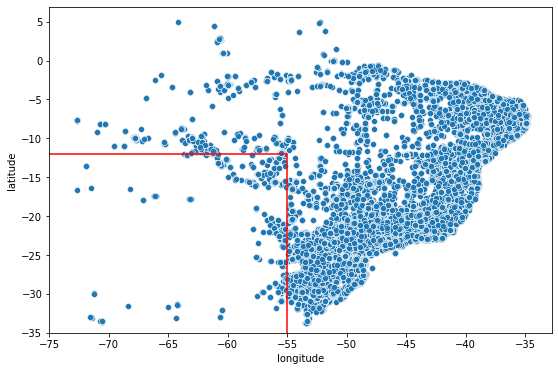

In [18]:
plt.figure(figsize=(9,6))
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])
plt.plot([-55, -55, -75], [-35, -12, -12], c='r')
plt.xlim(-75)
plt.ylim(-35)

First we'll deal with the foreign data. We could use the 'geopy' library to check all the coordinates and return their countries' names, but with almost 170.000 different values this would take a very long time, so we need a faster approach.

Knowing that all of the foreign data are in the left side of the map, we can choose a longitude point that would contain all of the foreign coordinates to the left and still doesn't contain too much brazilian points. We decided to draw a vertical line at longitude -53.4.

In [19]:
# Filter left side of map to a new variable
sudamerica = final_df[final_df['longitude'] < -53.4][['user_id', 'coordinates']]
sudamerica.reset_index(drop=True, inplace=True)
sudamerica_uniques = sudamerica['coordinates'].unique()
sudamerica['coordinates'].nunique()

9539

This new section has only 9.539 different coordinates. This will reduce the 'geopy' process to 1 hour and 30 minutes.

In [20]:
# %%time

# import geopy
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myGeocoder')

# list_loc = []
# for l in range(len(sudamerica_uniques)):
#     location = geolocator.reverse(sudamerica_uniques[l])
#     dict_location = location.raw['address']['country']
#     list_loc.append(dict_location)
#     print(l)

# new_locs = pd.DataFrame(list_loc)

# sudamerica_uniques = pd.DataFrame(sudamerica_uniques)
# outsiders = sudamerica_uniques.merge(new_locs, left_index=True, right_index=True)

# outsiders = outsiders[outsiders['0_y'] != 'Brasil']

In [21]:
# New dataframe with foreign coordinates and their respective countries
outsiders = pd.read_csv('gs://appito_arenas_data/sudamerica.csv')
outsiders

,0_x,0_y
0,"3.643433,-54.028568",France
1,"3.643804,-54.028488",France
2,"-33.497773,-70.568182",Chile
3,"-24.975992,-54.920562",Paraguay
4,"-24.899808,-54.944365",Paraguay
...,...,...
181,"-24.064067,-54.307661",Paraguay
182,"-28.552277,-56.039833",Argentina
183,"-25.836378,-55.176982",Paraguay
184,"-25.874887,-55.627694",Paraguay


In [22]:
# Remove rows from 'final_df' with coordinates in 'outsiders'
for coords in outsiders['0_x']:
    final_df = final_df[final_df['coordinates'] != coords]
final_df

,user_id,latitude,longitude,origin,coordinates
203536,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
229825,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
49333,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
424183,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
565044,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
142778,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
906637,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
33816,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
416242,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


Now we have to deal with the two strange islands in the southeast coast.

In this case we can use the rectangle approach again, filtering to really small areas around them to check their coordinates.

In [23]:
# Display the islands' coordinates
print(final_df[(final_df['longitude'] > -48) & (final_df['longitude'] < -47.5) & (final_df['latitude'] > -26.88) & (final_df['latitude'] < -25.6)]['coordinates'].unique())
final_df[(final_df['longitude'] > -46.5) & (final_df['longitude'] < -45.5) & (final_df['latitude'] > -25.1) & (final_df['latitude'] < -24.5)]['coordinates'].unique()

['-26.608714,-47.887423']


array(['-24.687704,-45.953423'], dtype=object)

Searching for this coordinates on Google Maps, we can see that they're in the middle of the ocean, so we have to discard them

In [24]:
# Drop rows in final_df with these coordinates
final_df = final_df[(final_df['coordinates'] != '-26.608714,-47.887423') & (final_df['coordinates'] != '-24.687704,-45.953423')]
final_df.reset_index(drop=True, inplace=True)
final_df

,user_id,latitude,longitude,origin,coordinates
0,0x000034F383E0A1F82F6F251B17B7611A,-8.208950,-34.958598,M,"-8.20895,-34.958598"
1,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
2,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
3,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
4,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
...,...,...,...,...,...
313442,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
313443,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
313444,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
313445,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


### 2.3: checking for 'C' coordinates

In order to keep the model unbiased by the matches locations, we need to check and discard users that doesn't have a 'C' coordinate. For that, we'll create new binary columns and grouped them by 'user_id' to check the sum.

In [25]:
origin_check = final_df.copy()
origin_check['C'] = final_df['origin'].apply(lambda x: 1 if x == 'C' else 0)
origin_check['M'] = final_df['origin'].apply(lambda x: 1 if x == 'M' else 0)
group = origin_check.groupby('user_id', as_index=False).agg({'C': np.sum, 'M': np.sum})
group['C'].value_counts()

1    124204
0      2733
Name: C, dtype: int64

There are 2.690 users with no 'C' coordinate, so we have to discard them:

In [26]:
# Copy the ids of users withou 'C' to a variable
no_C = group[group['C'] == 0]['user_id'].values

# Drop rows in final_df with those ids
for user in no_C:
    final_df = final_df[final_df['user_id'] != user]
final_df['user_id'].nunique()

124204

Now our dataframe has 124.204 different users, all of them having a 'C' and a 'M' coordinates. This is our final dataframe, with clean, real and brazilian based data.

We can visually check the result in the map plotted bellow:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

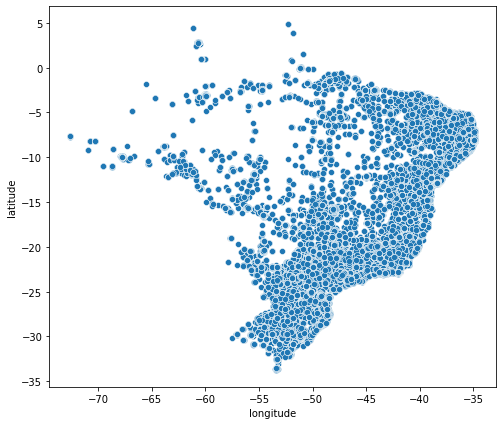

In [27]:
plt.figure(figsize=(8,7))
sns.scatterplot(x=final_df['longitude'], y=final_df['latitude'])

In [28]:
# Display the final_df
final_df

,user_id,latitude,longitude,origin,coordinates
1,0x000077FF355F239607A3327FD90C82D2,-29.925139,-51.163535,C,"-29.925139,-51.163535"
2,0x000077FF355F239607A3327FD90C82D2,-29.930372,-51.162725,M,"-29.930372,-51.162725"
3,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.214658,-49.347787,M,"-25.214658,-49.347787"
4,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.434135,-49.265799,C,"-25.434135,-49.265799"
5,0x00018E5BD60A17CD41BB547D0034496C,2.773165,-60.724444,C,"2.773165,-60.724444"
...,...,...,...,...,...
313442,0xFFFF595F516EF7024A74D8594B7CC72E,-19.918043,-43.945335,M,"-19.918043,-43.945335"
313443,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.079803,-47.206807,C,"-23.079803,-47.206808"
313444,0xFFFFA4BFD55F033F1AE42997539F51D1,-23.096441,-47.230640,M,"-23.096441,-47.23064"
313445,0xFFFFFC97A8A9F1EDEC63F807F12F538B,-23.538271,-46.400885,M,"-23.538271,-46.400885"


## 3. Training and fitting

Now that we have our final dataframe with 309.388 rows, we need to feed it to our model. 

### 3.1: grouping by 'user_id'


After some analysis, we decided that the best way to do that was to give the model only one coordinate per user, taking the mean of all the locations of that user.

In [29]:
# Group final_df by 'user_id'
mean_user = final_df.groupby('user_id', as_index=False).agg({'latitude': np.mean, 'longitude': np.mean})

# Display the first rows
mean_user.head(5)

,user_id,latitude,longitude
0,0x000077FF355F239607A3327FD90C82D2,-29.927755,-51.163130
1,0x0000A09DE7C5FBBB72EE84E5A44E6E5C,-25.324396,-49.306793
2,0x00018E5BD60A17CD41BB547D0034496C,2.784756,-60.721383
3,0x0005014F8A548CDD4A201853D3BE74EB,-22.868730,-43.240398
4,0x00052935A7B810E27826BB3406780761,-21.153670,-47.830782


### 3.2: K-Means #1

Now that the input's ready, we can feed it to the model.

The KMeans is an unsupervised machine learning model, that labels the data into any given number of clusters. It's the best model to use when dealing with coordinates

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

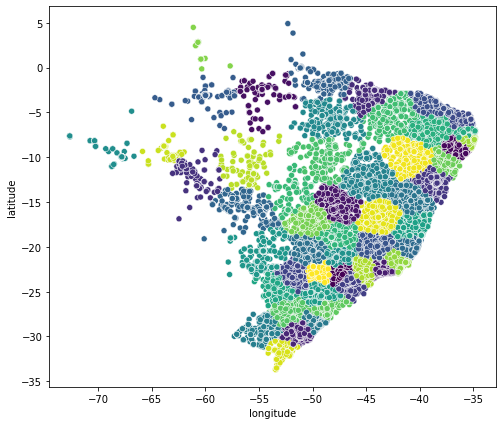

In [30]:
# Copy only necessary features to a new variable
X = mean_user[['latitude', 'longitude']]

# Instantiante a KMeans with 50 clusters and fit it to X
km50 = KMeans(n_clusters=50, random_state=1)
km50.fit(X)

# Plot the original dataframe with designated clusters
plt.figure(figsize=(8,7))
sns.scatterplot(x=X['longitude'], y=X['latitude'], c=km50.labels_)

The map above shows us the division of the 50 clusters the model calculated. It's clear that the northwestern users are more dispersed while the southeastern users are more numbered and closely gathered. 


Now that we have the clusters, we need to calculate and analyze their locations and numbers of users. The model attributes a label/number and a centroid (center location) for each cluster.

In [31]:
# Create a dataframe of centroids' coordinates
centroids = pd.DataFrame(km50.cluster_centers_)
centroids.columns = ['centroid_latitude', 'centroid_longitude']
centroids['coordinates'] = round(centroids['centroid_latitude'], 6).astype(str) + ',' + round(centroids['centroid_longitude'], 6).astype(str)

# Create a dataframe of designated labels per user 
clusters = pd.DataFrame(pd.DataFrame(km50.labels_).value_counts().sort_index())
clusters.columns = ['nb_of_users']
clusters.reset_index(drop=True, inplace=True)

# Merge them and sorte by number of users
clusters_info = clusters.merge(centroids, left_index=True, right_index=True)
clusters_info['label'] = clusters_info.index
clusters_info.sort_values('nb_of_users', ascending=False).head(10)

,nb_of_users,centroid_latitude,centroid_longitude,coordinates,label
9,26099,-23.592930,-46.607312,"-23.59293,-46.607312",9
4,10977,-22.754726,-43.335717,"-22.754726,-43.335717",4
13,6045,-19.948321,-43.983896,"-19.948321,-43.983896",13
0,5359,-22.990579,-47.287872,"-22.990579,-47.287872",0
5,5174,-29.779276,-51.199205,"-29.779276,-51.199205",5
27,4421,-25.438952,-49.289371,"-25.438952,-49.289371",27
37,4307,-27.018249,-48.771698,"-27.018249,-48.771698",37
8,4052,-12.754281,-38.606806,"-12.754281,-38.606806",8
42,4029,-8.087716,-35.071499,"-8.087716,-35.071499",42
3,3463,-15.836250,-47.983347,"-15.83625,-47.983347",3


The results listed above shows that the top 1 cluster has 26.099 users and it's centroid is in the city of São Paulo. From this point forward, we'll focus on one of these clusters.


First, we're gonna filter the entire dataset to select only the users labeled to the top 1 cluster.

In [32]:
# Apply the designated label for each user
km50_results = mean_user.merge(pd.DataFrame(km50.labels_), left_index=True, right_index=True)
km50_results.rename(columns={0: 'label'}, inplace=True)

# New dataframe 'top1', keeping only users with top 1 label
top1 = km50_results[km50_results['label'] == clusters_info.sort_values('nb_of_users', ascending=False)['label'].values[0]]
top1

,user_id,latitude,longitude,label
6,0x0006B527DD261EBBBC2222CFC7F42381,-23.522237,-46.856618,9
11,0x0007F9CC1C5D3E9FA36E0E4A6E12F80C,-23.602084,-46.693084,9
14,0x000AA768B732B483C4B63AAEB4089B4D,-23.497683,-46.613610,9
24,0x000F1FDD7CD3D4E9C501087FFE30B60E,-23.626863,-46.598445,9
28,0x001067BFB9BD0A1AAF71F410B2B2C39F,-23.545778,-46.444077,9
...,...,...,...,...
124172,0xFFEFD23ED5398D9AFF039F832FD030CE,-23.573478,-46.427033,9
124177,0xFFF3EA6A995FE822B2149B6A604C2808,-23.447789,-46.380845,9
124178,0xFFF434506FF338CC8D04936DA1613A56,-23.553122,-46.601391,9
124185,0xFFF72DFCF169AB7387FE7DD75250C422,-23.753299,-46.789680,9


In [33]:
# Drop 'label' column
top1 = top1.drop(columns=['label'])
top1.reset_index(drop=True, inplace=True)
top1

,user_id,latitude,longitude
0,0x0006B527DD261EBBBC2222CFC7F42381,-23.522237,-46.856618
1,0x0007F9CC1C5D3E9FA36E0E4A6E12F80C,-23.602084,-46.693084
2,0x000AA768B732B483C4B63AAEB4089B4D,-23.497683,-46.613610
3,0x000F1FDD7CD3D4E9C501087FFE30B60E,-23.626863,-46.598445
4,0x001067BFB9BD0A1AAF71F410B2B2C39F,-23.545778,-46.444077
...,...,...,...
26094,0xFFEFD23ED5398D9AFF039F832FD030CE,-23.573478,-46.427033
26095,0xFFF3EA6A995FE822B2149B6A604C2808,-23.447789,-46.380845
26096,0xFFF434506FF338CC8D04936DA1613A56,-23.553122,-46.601391
26097,0xFFF72DFCF169AB7387FE7DD75250C422,-23.753299,-46.789680


Now we have a smaller dataframe containing only the 26.099 users that the model classified for the label 9.

### 3.3: K-Means #2 (Constrained)

Now we're gonna input the top1 dataframe to a K-Means algorithm again, but with a slight difference: restricting the clusters' size. That's important because the arena must be close to 500 real users to be financially viable.


In order to do that, we'll use the variant 'K-Means Constrained', that enables the restrictions of size (min and/or max) and number of clusters. 

In [46]:
%%time

# Copy features to a new variable
X_top1 = top1[['latitude', 'longitude']]

# Parameters of the model
size_max_model = 4000
size_min_model = 500
max_iter_model = 100

# Instantiate and fit the model
km_top1 = KMeansConstrained(#size_max=size_max_model,
                            size_min=size_min_model,
                            max_iter=max_iter_model,
                            random_state=0)
km_top1.fit(X_top1)

CPU times: user 4min 1s, sys: 2min 28s, total: 6min 30s
Wall time: 1min 18s


KMeansConstrained(copy_x=True, init='k-means++', max_iter=100, n_clusters=8,
         n_init=10, n_jobs=1, random_state=0, size_max=None, size_min=500,
         tol=0.0001, verbose=False)

The model returned 8 'sub-clusters'. We'll build a dataframe with important info of each sub-cluster, so we can analyze and decide the best spot to build the arena.

In [47]:
# Merge sub-clusters' centroids and labels to a new dataframe
centroids_top1 = pd.DataFrame(km_top1.cluster_centers_)
centroids_top1.columns = ['centroid_latitude', 'centroid_longitude']
centroids_top1['centroid_coordinates'] = round(centroids_top1['centroid_latitude'], 6).astype(str)\
                                               + ',' + round(centroids_top1['centroid_longitude'], 6).astype(str)
clusters_top1 = pd.DataFrame(pd.DataFrame(km_top1.labels_).value_counts().sort_index())
clusters_top1.columns = ['nb_of_users']
clusters_top1.reset_index(drop=True, inplace=True)

results_top1 = pd.merge(centroids_top1, clusters_top1, left_index=True, right_index=True)
results_top1['label'] = results_top1.index

# Display the dataframe
results_top1

,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_users,label
0,-23.179059,-46.679556,"-23.179059,-46.679556",776,0
1,-23.664591,-46.615619,"-23.664591,-46.615619",5295,1
2,-24.182046,-47.011735,"-24.182046,-47.011735",500,2
3,-23.578764,-46.814993,"-23.578764,-46.814993",4994,3
4,-23.519750,-46.667787,"-23.51975,-46.667787",6005,4
5,-23.526228,-46.460962,"-23.526228,-46.460962",6112,5
6,-23.967490,-46.344330,"-23.96749,-46.34433",1744,6
7,-23.457078,-46.103619,"-23.457078,-46.103619",673,7


We have a dataframe with all 'sub-clusters' centroids, number of users and designated label.

In the map bellow we can see the distribution of 'sub-clusters' through São Paulo's area.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

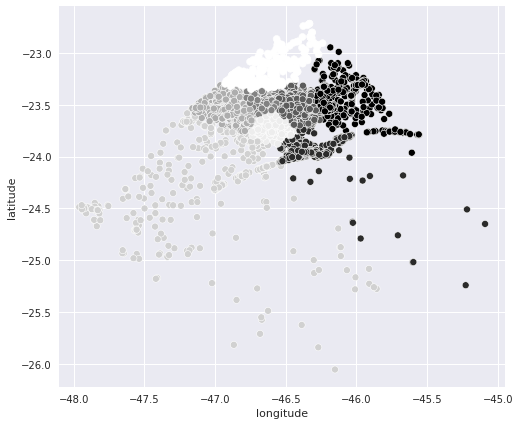

In [48]:
plt.figure(figsize=(8,7))
sns.scatterplot(x=X_top1['longitude'], y=X_top1['latitude'], c=km_top1.labels_)

## 4. New features for analysis

Now we're gonna add some important features of these 'sub-clusters' to improve the analysis and aid the business decision.

### 4.1: distance

We'll build a new feature that calculates the distance between every user and it's designated centroid, using a navigation formula called 'haversine', that takes coordinates and returns the distance in km; luckily for us, there's a python's library for that.

In [49]:
# Merge top1 with labels
distance_top1 = top1.merge(pd.DataFrame(km_top1.labels_), left_index=True, right_index=True)
distance_top1.rename(columns={0: 'label'}, inplace=True)

# Add centroids' coordinates to each user, to enable distance calculation
distance_top1['centroid_coord'] = None
for row in range(len(results_top1)):
    distance_top1.loc[distance_top1['label'] == results_top1['label'][row], 'centroid_coord' ]\
                      = results_top1['centroid_coordinates'][row]

# Split centroids' coordinates to 'centroid_lat' and 'centroid_long' and rename the users' lat and long
distance_top1['centroid_lat'] = distance_top1['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_top1['centroid_long'] = distance_top1['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)
distance_top1.rename(columns={'latitude': 'user_lat','longitude': 'user_long'}, inplace=True)

# Apply 'haversine' method to a column 'distance_km'
distance_top1['distance_km'] = 0.0
for row in distance_top1.index:
    distance_top1['distance_km'][row] = round(haversine(
                                              [distance_top1['user_lat'][row], distance_top1['user_long'][row]],
                                              [distance_top1['centroid_lat'][row], distance_top1['centroid_long'][row]]), 2)
distance_top1.head(10)

/tmp/ipykernel_2109/547558181.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_top1['distance_km'][row] = round(haversine(


,user_id,user_lat,user_long,label,centroid_coord,centroid_lat,centroid_long,distance_km
0,0x0006B527DD261EBBBC2222CFC7F42381,-23.522237,-46.856618,3,"-23.578764,-46.814993",-23.578764,-46.814993,7.58
1,0x0007F9CC1C5D3E9FA36E0E4A6E12F80C,-23.602084,-46.693084,4,"-23.51975,-46.667787",-23.519750,-46.667787,9.51
2,0x000AA768B732B483C4B63AAEB4089B4D,-23.497683,-46.613610,4,"-23.51975,-46.667787",-23.519750,-46.667787,6.04
3,0x000F1FDD7CD3D4E9C501087FFE30B60E,-23.626863,-46.598445,1,"-23.664591,-46.615619",-23.664591,-46.615619,4.55
4,0x001067BFB9BD0A1AAF71F410B2B2C39F,-23.545778,-46.444077,5,"-23.526228,-46.460962",-23.526228,-46.460962,2.77
5,0x00110DB5B332B4B5F7B6C6A62BA5CF09,-23.613508,-46.784491,3,"-23.578764,-46.814993",-23.578764,-46.814993,4.96
6,0x00120296C2B03D1B232CE8FE54E61642,-23.575472,-46.801437,3,"-23.578764,-46.814993",-23.578764,-46.814993,1.43
7,0x0012F7C74A1C743CCA0468C3F97F2207,-23.971426,-46.274487,6,"-23.96749,-46.34433",-23.967490,-46.344330,7.11
8,0x00181B740357B70C0C3EAF76133192ED,-23.529814,-46.472259,5,"-23.526228,-46.460962",-23.526228,-46.460962,1.22
9,0x0019348117245803450CBB299683F4E1,-23.517928,-46.714270,4,"-23.51975,-46.667787",-23.519750,-46.667787,4.74


Now, the 'distance_top1' enables us to take the mean distance between users and centroids per 'sub-cluster'. Then, we can merge this with the 'results_top1' dataframe and add some extra distance features to it.

In [50]:
# Take the mean and max distance per cluster
mean_dist_label = distance_top1.groupby('label').agg({'distance_km': [np.mean, np.max]})

# Merge the results
final_top1 = results_top1.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_top1.rename(columns={final_top1.columns[-2]: 'mean_distance', final_top1.columns[-1]: 'max_distance'}, inplace=True)

# creating new columns that shows the 3rd quartile for each cluster:
for i in range(len(final_top1)):
    final_top1.loc[i,'25%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_top1.loc[i,'50%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['50%'], 2)
    final_top1.loc[i,'75%'] = round(distance_top1[distance_top1['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_top1.sort_values('mean_distance', inplace=True)
final_top1.reset_index(drop=True, inplace=True)
final_top1.head(10)

/home/franciscodidier/.pyenv/versions/3.8.6/envs/Appito_Arenas/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,centroid_latitude,centroid_longitude,centroid_coordinates,nb_of_users,label,mean_distance,max_distance,25%,50%,75%
0,-23.519750,-46.667787,"-23.51975,-46.667787",6005,4,6.65,22.30,4.36,6.68,8.47
1,-23.664591,-46.615619,"-23.664591,-46.615619",5295,1,7.86,24.31,5.28,7.72,10.07
2,-23.526228,-46.460962,"-23.526228,-46.460962",6112,5,9.04,26.87,5.78,9.03,11.46
3,-23.967490,-46.344330,"-23.96749,-46.34433",1744,6,9.04,181.11,3.22,6.96,11.53
4,-23.578764,-46.814993,"-23.578764,-46.814993",4994,3,9.49,36.31,6.11,8.53,11.19
5,-23.457078,-46.103619,"-23.457078,-46.103619",673,7,18.91,75.55,12.05,15.94,22.11
6,-23.179059,-46.679556,"-23.179059,-46.679556",776,0,19.10,62.36,13.14,16.64,22.60
7,-24.182046,-47.011735,"-24.182046,-47.011735",500,2,51.78,225.37,31.82,44.47,61.60


### 4.2: distribution

Now we have a dataframe presenting all of top1's 'sub-clusters' and some important features of them. The first sub-cluster of the table above has 5943 users, with a mean distance between users and centroid of 6.62 km, and the most distant user is 22.29 km far from the centroid. Also, 75% of all users of this sub-cluster are inside a radius of 8.42 km.


The plot bellow shows the distribution the top 4 sub-clusters: <font color='blue'>Users</font>, <font color='red'>centroids</font> and **Appito Arena SP**.

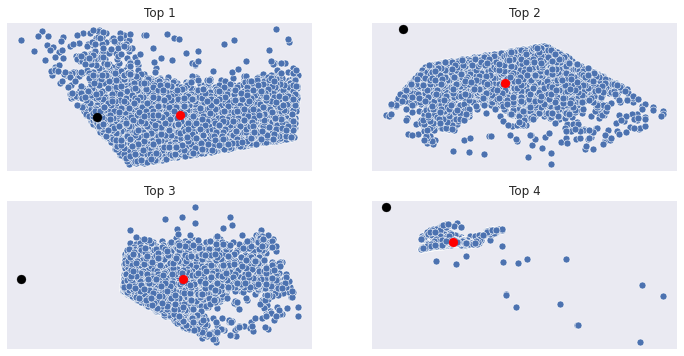

In [51]:
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_top1[distance_top1['label'] == final_top1['label'][i]]['user_long'],
                    y=distance_top1[distance_top1['label'] == final_top1['label'][i]]['user_lat'])
    plt.scatter(x=final_top1['centroid_longitude'][i], y=final_top1['centroid_latitude'][i], color='r', s=80)
    plt.scatter(x=-46.743107712605976, y=-23.524052597676175, color='black', s=80)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

### 4.3: geographic features


Now we'll add geographical info to the dataframe by using 'geopy' module once more. This python package accepts coordinates as inputs and returns all the hole address of it.

In [52]:
# Instantiate geopy
geolocator = Nominatim(user_agent="myGeocoder")

# Extract location info and add to a new dataframe 'location'
keys = ['suburb', 'town', 'city', 'state']
list_loc = []

for l in range(len(final_top1['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_top1['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'state'])
    for key in keys:
        dict_location = {key: dict_location.get(key) for key in keys}
    list_loc.append(dict_location)

location = pd.DataFrame(list_loc)

# Copy 'centroid_coordinates' and merge with final_top1
location['centroid_coordinates'] = final_top1['centroid_coordinates']
geo_clusters = final_top1.merge(location, on='centroid_coordinates')

# Merge 'town' and 'city' and drop useless columns
for row in range(len(geo_clusters['city'])):
    if geo_clusters['city'][row] == None:
        geo_clusters['city'][row] = geo_clusters['town'][row]
geo_clusters.drop(columns=['centroid_latitude', 'centroid_longitude', 'town'], inplace=True)

# Display the top rows
geo_clusters.head(10)

/tmp/ipykernel_2109/2976904624.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clusters['city'][row] = geo_clusters['town'][row]


,centroid_coordinates,nb_of_users,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state
0,"-23.51975,-46.667787",6005,4,6.65,22.30,4.36,6.68,8.47,Barra Funda,None,São Paulo
1,"-23.664591,-46.615619",5295,1,7.86,24.31,5.28,7.72,10.07,Taboão,Diadema,São Paulo
2,"-23.526228,-46.460962",6112,5,9.04,26.87,5.78,9.03,11.46,Vila Guarani,São Paulo,São Paulo
3,"-23.96749,-46.34433",1744,6,9.04,181.11,3.22,6.96,11.53,Pompéia,Santos,São Paulo
4,"-23.578764,-46.814993",4994,3,9.49,36.31,6.11,8.53,11.19,Jardim Santa Maria,Osasco,São Paulo
5,"-23.457078,-46.103619",673,7,18.91,75.55,12.05,15.94,22.11,None,Guararema,São Paulo
6,"-23.179059,-46.679556",776,0,19.10,62.36,13.14,16.64,22.60,None,Jarinu,São Paulo
7,"-24.182046,-47.011735",500,2,51.78,225.37,31.82,44.47,61.60,Bambú,Peruíbe,São Paulo


### 4.4: economic feature

We're also gonna add the 'GDP per capita' of each city to help evaluate the centroids and aid the decision about the place.
We'll do this by importing a done table with this information for every city in Brazil and merging with our dataframe.

In [53]:
# Import 'gdp_percapita' table
gdp_pc = pd.read_csv('gs://appito_arenas_data/gdp_percapita_UF.csv')
gdp_pc.head(10)

,city,UF,gdp_pc_R$
0,Tremedal,BA,3140.24
1,Turuçu,RS,11430.97
2,Vitória,ES,61790.59
3,Jacutinga,MG,11567.21
4,Nazária,PI,2653.75
5,Pedra Azul,MG,7212.45
6,Teresina,PI,10841.20
7,Amarante,PI,3650.95
8,Matrinchã,GO,10387.00
9,Cachoeirinha,PE,4438.22


In [54]:
# Add gdp per capita to geo_clusters
geo_clusters = geo_clusters.merge(gdp_pc[gdp_pc['UF'] == 'SP'], on='city', how='left')
geo_clusters

,centroid_coordinates,nb_of_users,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state,UF,gdp_pc_R$
0,"-23.51975,-46.667787",6005,4,6.65,22.30,4.36,6.68,8.47,Barra Funda,None,São Paulo,NaN,NaN
1,"-23.664591,-46.615619",5295,1,7.86,24.31,5.28,7.72,10.07,Taboão,Diadema,São Paulo,SP,25066.30
2,"-23.526228,-46.460962",6112,5,9.04,26.87,5.78,9.03,11.46,Vila Guarani,São Paulo,São Paulo,SP,35271.93
3,"-23.96749,-46.34433",1744,6,9.04,181.11,3.22,6.96,11.53,Pompéia,Santos,São Paulo,SP,54054.76
4,"-23.578764,-46.814993",4994,3,9.49,36.31,6.11,8.53,11.19,Jardim Santa Maria,Osasco,São Paulo,SP,43994.47
5,"-23.457078,-46.103619",673,7,18.91,75.55,12.05,15.94,22.11,None,Guararema,São Paulo,SP,15919.36
6,"-23.179059,-46.679556",776,0,19.10,62.36,13.14,16.64,22.60,None,Jarinu,São Paulo,SP,17486.51
7,"-24.182046,-47.011735",500,2,51.78,225.37,31.82,44.47,61.60,Bambú,Peruíbe,São Paulo,SP,10653.18


Now we have a dataframe with all 8 optimal coordinates that our model returned, in addition to some important info on each one of them: 

- number of users 
- mean and max distance (user x centroid) 
- 1st, 2nd and 3rd quartile (distribution) 
- location info (suburb, city, state)
- GDP per capita of the city 

We believe this is enough to make a smart business decision about building the arena.

## Extra 1: Zap Imóveis scrapping


As an extra content, our project also offers real estate information. Once you've chosen the best potential(s) spots based on our model's output, we'll show you all empty lands available in that suburb registered on 'Zap Imóveis', one of the top real estate websites in Brazil.


For instance, we choose the 2nd cluster's suburb:

In [55]:
# Create a string with suburb's name 
suburb = 'Pompéia'

In [56]:
# Create column in scrapping format
geo_clusters['param_scrapping'] = (geo_clusters['UF'] +'+'+ geo_clusters["city"].replace(' ','-',regex=True)\
                                  +'++'+geo_clusters["suburb"].replace(' ','-',regex=True)).str.normalize('NFKD')\
                                  .str.encode('ascii', errors='ignore')\
                                  .str.decode('utf-8').str.lower()

# Copy index of chosen suburb to a new variable 
sub_index = geo_clusters[geo_clusters['suburb'] == suburb]['param_scrapping'].index[0]

# Execute scrapping process using 'zapimoveis_scrapper'
scrapping_info = []
tipo = "terrenos-lotes-comerciais" #galpao-deposito-armazem
pages = 10
acao = 'aluguel'# venda

try:
    param_scrapping = geo_clusters["param_scrapping"][sub_index].replace('vila', 'vl')
    df_forloop = zap.search(localization=param_scrapping, num_pages=pages, tipo=tipo, dictionary_out=True, acao=acao)
    df_forloop = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df_forloop.items() ]))
    df_forloop['city'] = geo_clusters["city"][sub_index]
    df_forloop['state'] = geo_clusters["state"][sub_index]
    df_forloop['suburb'] = geo_clusters["suburb"][sub_index]
    scrapping_info.append(df_forloop)
    scrapping_info = pd.concat(scrapping_info)
except:
    print('Sorry! There are currently zero options available for this suburb in Zap Imóveis')
    pass
scrapping_info

,price,bedrooms,bathrooms,vacancies,total_area_m2,address,description,link,city,state,suburb
0,14500,0,0,0,672,Pompeia,Lote/Terreno para aluguel e venda - 672 metros...,/imovel/aluguel-terreno-lote-comercial-pompeia...,Santos,São Paulo,Pompéia


The output shows 1 available empty land for rent in the suburb of 'Pompéia', in the city of Santos/SP, in addition to the price, area in m2, address, description and the link of the place at Zap Imóveis website.

## Extra 2: K-Means 2.2

What about the results for other clusters? In the next cell we run the results for the top 2 cluster, based on the city of Rio de Janeiro:

<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/franciscodidier/.pyenv/versions/3.8.6/envs/Appito_Arenas/lib/python3.8/site-packages/pandas/core/frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(
<timed exec>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 19.7 s, sys: 5.46 s, total: 25.2 s
Wall time: 18.2 s


,centroid_coordinates,nb_of_users,label,mean_distance,max_distance,25%,50%,75%,suburb,city,state,UF,gdp_pc_R$
0,"-22.859788,-43.070666",1470,4,6.84,22.84,4.01,6.19,8.93,Morro do Castro,São Gonçalo,Rio de Janeiro,RJ,9699.16
1,"-22.906925,-43.287647",3282,6,7.50,20.55,4.83,7.32,9.78,Lins de Vasconcelos,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
2,"-22.783053,-43.390192",2449,1,8.17,50.51,4.70,7.37,10.50,Grande Rio,São João de Meriti,Rio de Janeiro,RJ,8514.39
3,"-21.763269,-43.40052",641,2,11.92,79.41,4.73,5.74,8.43,Cruzeiro de Santo Antônio,Juiz de Fora,Minas Gerais,NaN,NaN
4,"-22.878781,-43.598909",1324,5,12.04,94.95,6.04,9.95,16.53,Campo Grande,Rio de Janeiro,Rio de Janeiro,RJ,28405.95
5,"-22.478391,-43.132327",669,7,16.91,51.39,8.97,16.73,19.52,Cascatinha,Petrópolis,Rio de Janeiro,RJ,18504.77
6,"-22.801391,-42.747294",500,0,20.64,59.30,14.02,17.70,22.83,Bulhões,Tanguá,Rio de Janeiro,RJ,7841.65
7,"-22.61443,-44.097854",642,3,26.53,102.58,11.84,15.89,42.09,None,Barra Mansa,Rio de Janeiro,RJ,19866.10


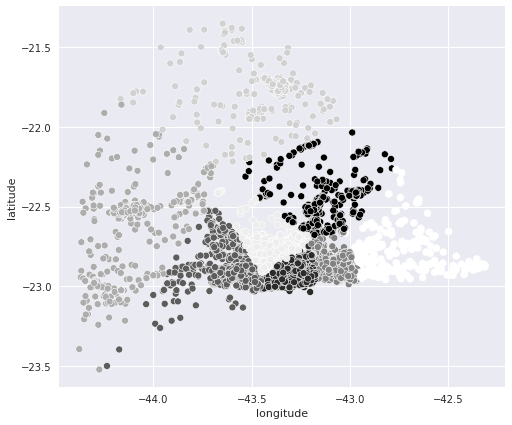

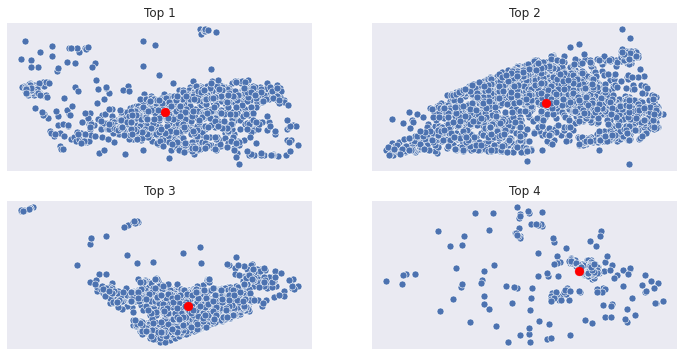

In [57]:
%%time

km50_results = mean_user.merge(pd.DataFrame(km50.labels_), left_index=True, right_index=True)
km50_results.rename(columns={0: 'label'}, inplace=True)
top2 = km50_results[km50_results['label'] == clusters_info.sort_values('nb_of_users', ascending=False)['label'].values[1]]
top2 = top2.drop(columns=['label'])
top2.reset_index(drop=True, inplace=True)
X_top2 = top2[['latitude', 'longitude']]
km_top2 = KMeansConstrained(size_min=500,max_iter=100,random_state=1)
km_top2.fit(X_top2)
centroids_top2 = pd.DataFrame(km_top2.cluster_centers_)
centroids_top2.columns = ['centroid_latitude', 'centroid_longitude']
centroids_top2['centroid_coordinates'] = round(centroids_top2['centroid_latitude'], 6).astype(str)\
                                               + ',' + round(centroids_top2['centroid_longitude'], 6).astype(str)
clusters_top2 = pd.DataFrame(pd.DataFrame(km_top2.labels_).value_counts().sort_index())
clusters_top2.columns = ['nb_of_users']
clusters_top2.reset_index(drop=True, inplace=True)
results_top2 = pd.merge(centroids_top2, clusters_top2, left_index=True, right_index=True)
results_top2['label'] = results_top2.index
plt.figure(figsize=(8,7))
sns.scatterplot(x=X_top2['longitude'], y=X_top2['latitude'], c=km_top2.labels_)
distance_top2 = top2.merge(pd.DataFrame(km_top2.labels_), left_index=True, right_index=True)
distance_top2.rename(columns={0: 'label'}, inplace=True)
distance_top2['centroid_coord'] = None
for row in range(len(results_top2)):
    distance_top2.loc[distance_top2['label'] == results_top2['label'][row], 'centroid_coord' ]\
                      = results_top2['centroid_coordinates'][row]
distance_top2['centroid_lat'] = distance_top2['centroid_coord'].apply(lambda x: x.split(',')[0]).astype(float)
distance_top2['centroid_long'] = distance_top2['centroid_coord'].apply(lambda x: x.split(',')[1]).astype(float)
distance_top2.rename(columns={'latitude': 'user_lat','longitude': 'user_long'}, inplace=True)
distance_top2['distance_km'] = 0.0
for row in distance_top2.index:
    distance_top2['distance_km'][row] = round(haversine(
                                              [distance_top2['user_lat'][row], distance_top2['user_long'][row]],
                                              [distance_top2['centroid_lat'][row], distance_top2['centroid_long'][row]]), 2)
mean_dist_label = distance_top2.groupby('label').agg({'distance_km': [np.mean, np.max]})
final_top2 = results_top2.merge(round(mean_dist_label, 2), left_index=True, right_index=True )
final_top2.rename(columns={final_top2.columns[-2]: 'mean_distance', final_top2.columns[-1]: 'max_distance'}, inplace=True)
for i in range(len(final_top2)):
    final_top2.loc[i,'25%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['25%'], 2)
    final_top2.loc[i,'50%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['50%'], 2)
    final_top2.loc[i,'75%'] = round(distance_top2[distance_top2['label'] == i]['distance_km'].describe().loc['75%'], 2)
final_top2.sort_values('mean_distance', inplace=True)
final_top2.reset_index(drop=True, inplace=True)
plt.figure(figsize=(12, 6))
plt.style.use('seaborn')
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(f'Top {i+1}')
    sns.scatterplot(x=distance_top2[distance_top2['label'] == final_top2['label'][i]]['user_long'],
                    y=distance_top2[distance_top2['label'] == final_top2['label'][i]]['user_lat'])
    plt.scatter(x=final_top2['centroid_longitude'][i], y=final_top2['centroid_latitude'][i], color='r', s=80)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
geolocator = Nominatim(user_agent="myGeocoder")
keys = ['suburb', 'town', 'city', 'state']
list_loc = []
for l in range(len(final_top2['centroid_coordinates'])):
    try:
        location = geolocator.reverse(final_top2['centroid_coordinates'][l])
        dict_location = location.raw['address']
    except:
        dict_location = dict(keys = ['suburb', 'town', 'city', 'state'])
    for key in keys:
        dict_location = {key: dict_location.get(key) for key in keys}
    list_loc.append(dict_location)
location = pd.DataFrame(list_loc)
location['centroid_coordinates'] = final_top2['centroid_coordinates']
geo_clusters2 = final_top2.merge(location, on='centroid_coordinates')
for row in range(len(geo_clusters2['city'])):
    if geo_clusters2['city'][row] == None:
        geo_clusters2['city'][row] = geo_clusters2['town'][row]
geo_clusters2.drop(columns=['centroid_latitude', 'centroid_longitude', 'town'], inplace=True)
geo_clusters2.head(10)
gdp_pc = pd.read_csv('gs://appito_arenas_data/gdp_percapita_UF.csv')
geo_clusters2 = geo_clusters2.merge(gdp_pc[gdp_pc['UF'] == 'RJ'], on='city', how='left')
geo_clusters2

## Conclusion

In this project we cleaned, analyzed and trained data from Appito, an app that organizes amateur soccer games, to help them decide the best spot to build a new Arena.

First, we received millions of raw data observations to clean. The output here was a dataframe close to 300k rows, containing only real users based on Brazil that played at least one match and shared their cellphone coordinates.

The second step was to group our datafame by 'user_id' and take the mean coordinates of each user, as a quick and valid measure of one's 'mean location', having so only one coordinate per user. This was the input used to train our machine learning model, K-Means, in order to split our dataset into a given number of clusters.  The output was a division of 50 clusters around the brazilian area. The top 10 clusters have a considerable number of users, and can be used for the next step of the project, a deeper analysis of a cluster.

The third step was to filter the final users' dataframe and select only users of a chosen cluster. Then we used them as input to another model called K-Means constrained, that allows you to limit the size of the new clusters. So the output was a division of sub-clusters, with maximum size of 1500 users each, and the centroid's coordinates for each sub-cluster. We then added some important features to help evaluate the optimal coordinates the model returned to us, like distance (km), distribution, geographical and economical info of the area.

As an extra step, our model provides real estate info of 'Zap Imóveis', one of the greatest websites on this matter, by only typing the name of the suburb to be searched for.

We believe that this project will help the app to choose the best spot to build their new Arena.